In [164]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer
import seaborn as sns

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} 
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [102]:
bucket_name = 'dats6450finalproject'
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


# Data Preprocessing

### Loading Data

In [103]:
bucket='dats6450finalproject'
data_key = 'framingham.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df=pd.read_csv(data_location)
df.head(5)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [104]:
print('The df dimensions are as follows:')
pd.DataFrame([[df.shape[0], df.shape[1]]], columns=['# rows', '# columns'])

The df dimensions are as follows:


,# rows,# columns
0,4238,16


In [105]:
df.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [106]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


### Missing Values

In [107]:
def nan_checker(df):
    # Get the dataframe of variables with NaN, their percentage of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isnull().sum()*100/len(df[var]), df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'percentage', 'dtype'])
    
    # Sort df_nan in accending order of the percentage of NaN
    df_nan = df_nan.sort_values(by='percentage', ascending=False).reset_index(drop=True)
    return df_nan

# Call nan_checker on df
df_nan = nan_checker(df)

# Get the variables with missing values, their percentage of missing values and dtype
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# Print df_miss
df_miss.sort_values(['percentage'], ascending=[False])

,var,percentage,dtype
0,glucose,9.155262,float64
1,education,2.477584,float64
2,BPMeds,1.250590,float64
3,totChol,1.179802,float64
4,cigsPerDay,0.684285,float64
5,BMI,0.448325,float64
6,heartRate,0.023596,float64


In [108]:
count=0
for i in df.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is', count)
print('This is',round((count/len(df.index))*100),'% of the entire dataset, therefore we will exclude the rows with missing values')

Total number of rows with missing values is 582
This is 14 % of the entire dataset, therefore we will exclude the rows with missing values


In [109]:
print('Before removing rows with missing values:')
pd.DataFrame([[df.shape[0], df.shape[1]]], columns=['# rows', '# columns'])

Before removing rows with missing values:


,# rows,# columns
0,4238,16


In [110]:
# Remove rows with missing values from df
df = df.dropna(subset=np.intersect1d(df_miss['var'], df.columns),
                           inplace=False)

print('After removing rows with missing values:')
pd.DataFrame([[df.shape[0], df.shape[1]]], columns=['# rows', '# columns'])

After removing rows with missing values:


,# rows,# columns
0,3656,16


# Exploratory Data Analysis (EDA) 

### Patient Demographics

In [111]:
print('The oldest patient: {} years.'.format(df["age"].max()))
print('The youngest patient: {} years.'.format(df["age"].min()))
print('Average age: {} years.'.format(df['age'].mean()))
print('Median age: {} years.'.format(df['age'].median(skipna=True)))

The oldest patient: 70 years.
The youngest patient: 32 years.
Average age: 49.5574398249453 years.
Median age: 49.0 years.


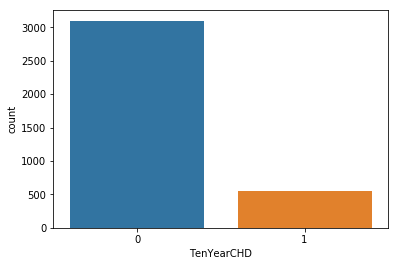

In [151]:
sns.countplot(df['TenYearCHD'])

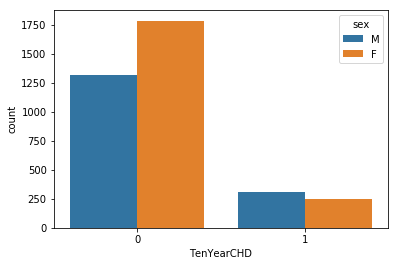

In [113]:
df.loc[(df.male==1),'male']='M'
df.loc[(df.male==0),'male']='F'
df=df.rename(columns={'male':'sex'})

sns.countplot(x = 'TenYearCHD', hue = 'sex', data = df)

In [129]:
#convert back to numerical
df=df.rename(columns={'sex':'male'})

In [131]:
df.loc[(df.male=='M'),'male']='1'
df.loc[(df.male=='F'),'male']='0'

Text(0.5, 1.0, 'Histogram of Age')

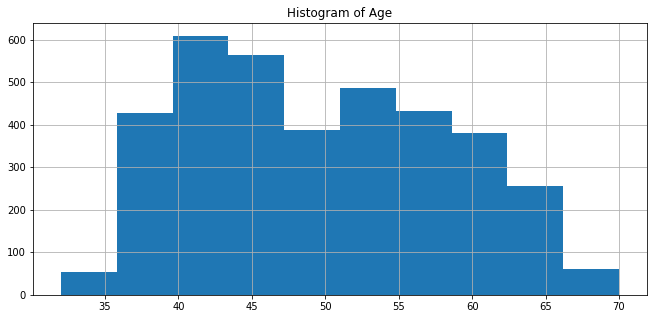

In [119]:
df['age'].hist(figsize=(11,5),bins=10)
plt.title('Histogram of Age')

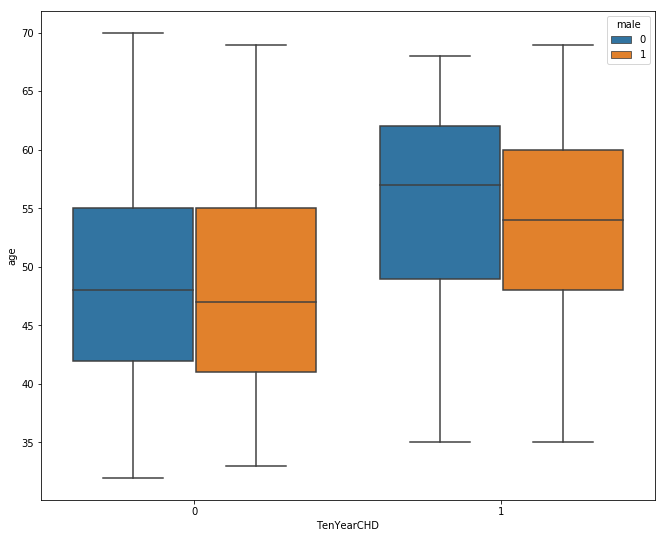

In [149]:
plt.figure(figsize = (11,9))
sns.boxplot( x = 'TenYearCHD', y = 'age',hue='male', data = df)

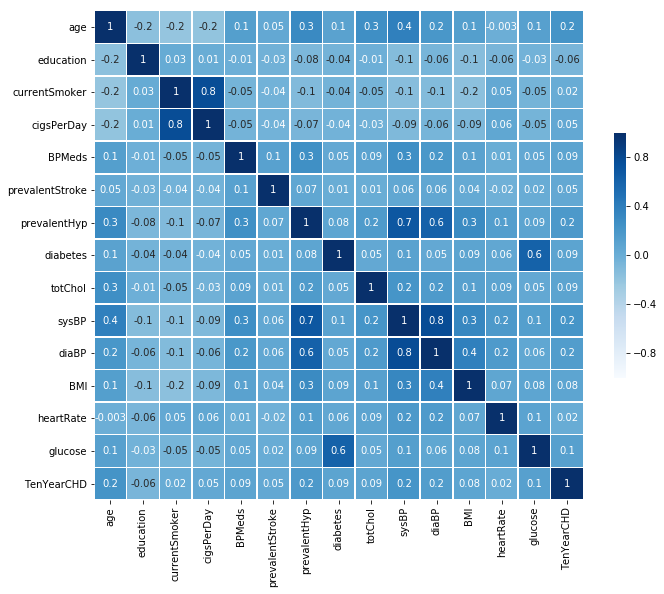

In [162]:
cor = df.corr()
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues,fmt='.1g',vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [121]:
# Identify the features with the most importance for the outcome variable Heart Disease

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# separate independent & dependent variables
x=df.drop('TenYearCHD', axis=1) #feature columns
y=df.TenYearCHD #target column i.e TenYearCHD

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Importance']  #naming the dataframe columns
featureScores = featureScores.sort_values(ascending=False, by='Importance') 
featureScores #print 10 best features

,Features,Importance
10,sysBP,669.506552
14,glucose,379.583137
1,age,295.507761
9,totChol,249.153078
4,cigsPerDay,156.567318
11,diaBP,142.878574
7,prevalentHyp,82.967184
8,diabetes,31.027987
5,BPMeds,28.153003
0,male,17.120430


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

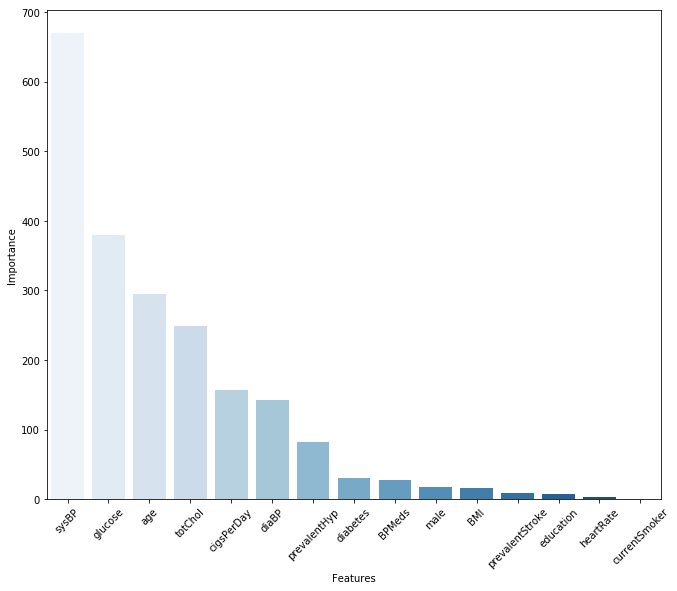

In [132]:
# Create a figure
fig = plt.figure(figsize=(11, 9))


# The bar plot of feature importance
sns.barplot(featureScores['Features'], featureScores['Importance'], palette = "Blues")

# Set x-axis
plt.xlabel('Features')

# Set y-axis
plt.ylabel('Importance')

plt.xticks(rotation=45)

### Split Data - Test/Train

In [167]:
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(df)), int(0.9 * len(df))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [175]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format('dats6450finalproject', prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format('dats6450finalproject', prefix), content_type='csv')

In [176]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format('dats6450finalproject', prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-04-22 09:12:34 Starting - Starting the training job...
2020-04-22 09:12:36 Starting - Launching requested ML instances......
2020-04-22 09:13:39 Starting - Preparing the instances for training......
2020-04-22 09:14:36 Downloading - Downloading input data...
2020-04-22 09:15:34 Training - Training image download completed. Training in progress.
2020-04-22 09:15:34 Uploading - Uploading generated training model.Arguments: train
[2020-04-22:09:15:30:INFO] Running standalone xgboost training.
[2020-04-22:09:15:30:INFO] File size need to be processed in the node: 0.19mb. Available memory size in the node: 8501.35mb
[2020-04-22:09:15:30:INFO] Determined delimiter of CSV input is ','
[09:15:30] S3DistributionType set as FullyReplicated
[09:15:30] 2559x15 matrix with 38385 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-04-22:09:15:30:INFO] Determined delimiter of CSV input is ','
[09:15:30] S3DistributionType set as FullyReplicated
[09:15:30] 731


2020-04-22 09:15:41 Completed - Training job completed
Training seconds: 65
Billable seconds: 65


In [177]:
compiled_model = xgb
try:
    xgb.create_model()._neo_image_account(boto3.Session().region_name)
except:
    print('Neo is not currently supported in', boto3.Session().region_name)
else:
    output_path = '/'.join(xgb.output_path.split('/')[:-1])
    compiled_model = xgb.compile_model(target_instance_family='ml_m4', 
                                   input_shape={'data':[1, 69]},
                                   role=role,
                                   framework='xgboost',
                                   framework_version='0.7',
                                   output_path=output_path)
    compiled_model.name = 'deployed-xgboost-customer-churn'
    compiled_model.image = get_image_uri(sess.boto_region_name, 'xgboost-neo', repo_version='latest')

?..!

In [178]:
xgb_predictor = compiled_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

---------------!

In [179]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

In [182]:
 def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [183]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,162,41
1,58,105


In [190]:
print('When looking at this, we can used the matrix to determin the accuracy by calculatin (TP+TN)/total. Therefore, the accuracy of the XGBoost Algorithm was 72.9%, which is not great and cann absolutely be improved.')

When looking at this, we can used the matrix to determin the accuracy by calculatin (TP+TN)/total. Therefore, the accuracy of the XGBoost Algorithm was 72.9%, which is not great and cann absolutely be improved.
